# <center> Lecture11 : Evaluating Regression Models </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

在lec10的末尾，我们引入了是否吸烟这个变量，并建立了一个新的回归模型。  

在本节课中，我们将讨论更复杂的模型，例如同时包含两个预测变量(压力和是否吸烟)，甚至是两个变量的交互项。  

🤔这节课需要关注的问题：  
1. 如何评估不同的模型？哪个模型最好？  
2. 什么时候该使用什么模型？  
3. 贝叶斯分析流程中各部分的意义。

## 模型回顾  

在之前的课程中，我们分别以压力和是否吸烟作为预测因子定了一般线性模型  

$$  
Y_i | \beta_0, \beta_1, \sigma \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i  
$$  

- 两种模型可以用相同的回归公式表示。  
- 区别在于：  
	- 两者的先验不同。  
	- 对于离散变量中回归系数的解释不同。  

<table>  
        <tr>  
					<td>模型</td>  
           <td>model1</td>  
					 <td> model2</td>  
        </tr>  
        <tr>  
            <td>自变量</td>  
					<td>压力(连续变量)</td>  
					<td>吸烟(离散变量)</td>  
        </tr>  
	  <tr>  
            <td>自变量含义</td>  
					<td>`0` 表示不吸烟，`1`表示吸烟</td>  
					<td>14-70的压力评级</td>  
   </tr>  
	 <tr>  
            <td>先验</td>  
					<td>  
β0 ~ N(45, 10) <br>  
β1 ~ N(0, 10)  <br>  
σ ~ Exp(0.6) <br>  
		 </td>  
					<td>  
β0 ~ N(45, 10)  <br>  
β1 ~ N(0, 10)  <br>  
σ ~ Exp(0.6) <br>  
		 </td>  
  </tr>  
	  <tr>  
            <td>可视化</td>  
					<td><img src="https://cdn.kesci.com/upload/s3y4rmsym1.png?imageView2/0/w/600/h/600" alt="" width="100" height="200"> </td>  
			<td><img src="https://cdn.kesci.com/upload/s40nk3kagu.png?imageView2/0/w/600/h/600" alt="" width="100" height="200"> </td>  
   </tr>  
</table>  



In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')

# 筛选站点为"Tsinghua"的数据
df = df_raw[df_raw["Site"] == "Tsinghua"]

# 选择需要的两列
df = df[["stress","scontrol","smoke"]]

#1 表示吸烟，2表示不吸烟
df["smoke"] =  np.where(df['smoke'] == 2, 0, 1)
df["smoke_recode"] =  np.where(df['smoke'] == 1, "yes", "no")

#设置索引
df["index"] = range(len(df))
df = df.set_index("index")

**快速运行模型定义、后验参数采样、后验预测分布部分**

In [3]:
with pm.Model() as model1:

    beta_0 = pm.Normal("beta_0", mu=45, sigma=10)        #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                 #定义sigma

    x = pm.MutableData("smoke",df.stress, dims="obs_id")                     #x是自变量压力水平
    mu = pm.Deterministic("mu", beta_0 + beta_1*x, dims="obs_id")            #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.scontrol, dims="obs_id")


with pm.Model() as model2:

    beta_0 = pm.Normal("beta_0", mu=45, sigma=10)        #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                 #定义sigma

    smoke = pm.MutableData("smoke",df.smoke, dims="obs_id")            #x为是否吸烟，0 1编码。
    mu = pm.Deterministic("mu", beta_0 + beta_1*smoke, dims="obs_id")  #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.scontrol, dims="obs_id")

In [4]:
#===========================
#     注意！！！以下代码可能需要运行5分钟左右
#===========================
with model1:
    model1_trace = pm.sample(draws=5000,                  # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

with model2:
    model2_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                   # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                    # 链数
                        discard_tuned_samples= True, # tune的结果将在采样结束后被丢弃
                        random_seed=84735)                     

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 75 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 49 seconds.


In [5]:
# 后验预测
with model1:
    model1_ppc = pm.sample_posterior_predictive(model1_trace, random_seed=84735)
with model2:
    model2_ppc = pm.sample_posterior_predictive(model2_trace, random_seed=84735)

Sampling: [y_est]


Sampling: [y_est]


### 评估后验预测  

这里我们仍然使用上节课介绍过的两个指标：**MAE**与**后验预测区间**。

#### MAE  

$$  
\text{MAE} = median\left(|Y_i - \hat{Y}_i|\right)  
$$  

MAE的结果显示：  
- 模型1的预测误差小于模型2，即模型1的预测能力优于模型2

In [6]:
# 定义计算 MAE 函数
from statistics import median
def MAE(model_ppc):
    # 计算每个X取值下对应的后验预测模型的均值
    pre_x = model_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))
    pre_y_mean = pre_x.mean(axis=1).values

    # 提取观测值Y，提取对应Y值下的后验预测模型的均值
    MAE = pd.DataFrame({
        "scontrol_ppc_mean": pre_y_mean,
        "scontrol_original": df.scontrol
    })

    # 计算预测误差
    MAE["pre_error"] = abs(MAE["scontrol_original"] -\
                            MAE["scontrol_ppc_mean"])

    # 最后，计算预测误差的中位数
    MAE = median(MAE.pre_error)
    return MAE

# 输出结果
model1_MAE = MAE(model1_ppc)
print(f"模型1(连续变量)MAE: {model1_MAE:.2f}")
model2_MAE = MAE(model2_ppc)
print(f"模型2(离散变量)MAE: {model2_MAE:.2f}")

模型1(连续变量)MAE: 3.40
模型2(离散变量)MAE: 4.45


#### 后验预测区间  

结果发现，两个模型中超出95%hdi的观测值的数量为9。

In [7]:
# 定义
def counter_outlier(model_ppc, hdi_prob=0.95):
    # 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
    hdi = az.summary(model_ppc, kind="stats", hdi_prob=hdi_prob)
    lower = hdi.iloc[:,2].values
    upper = hdi.iloc[:,3].values

    # 将原数据中的自我控制分数合并，便于后续进行判断
    y_obs = model_ppc.observed_data["y_est"].values

    # 判断原数据中的压力分数是否在后验预测的95%可信区间内，并计数
    hdi["verify"] = (y_obs <= lower) | (y_obs >= upper)
    hdi["y_obs"] = y_obs
    hdi_num = sum(hdi["verify"])

    return hdi_num

# 输出结果
model1_outliers = counter_outlier(model1_ppc)
print(f"模型1(连续变量)超出95%hdi: {model1_outliers:.2f}")
model2_outliers = counter_outlier(model2_ppc)
print(f"模型2(离散变量)超出95%hdi: {model2_outliers:.2f}")

模型1(连续变量)超出95%hdi: 9.00
模型2(离散变量)超出95%hdi: 9.00


### 后验预测分布  

* 通过 arviz 绘制两个模型的后验预测分布  
* 可见，两个模型对于数据总体的预测性能相当

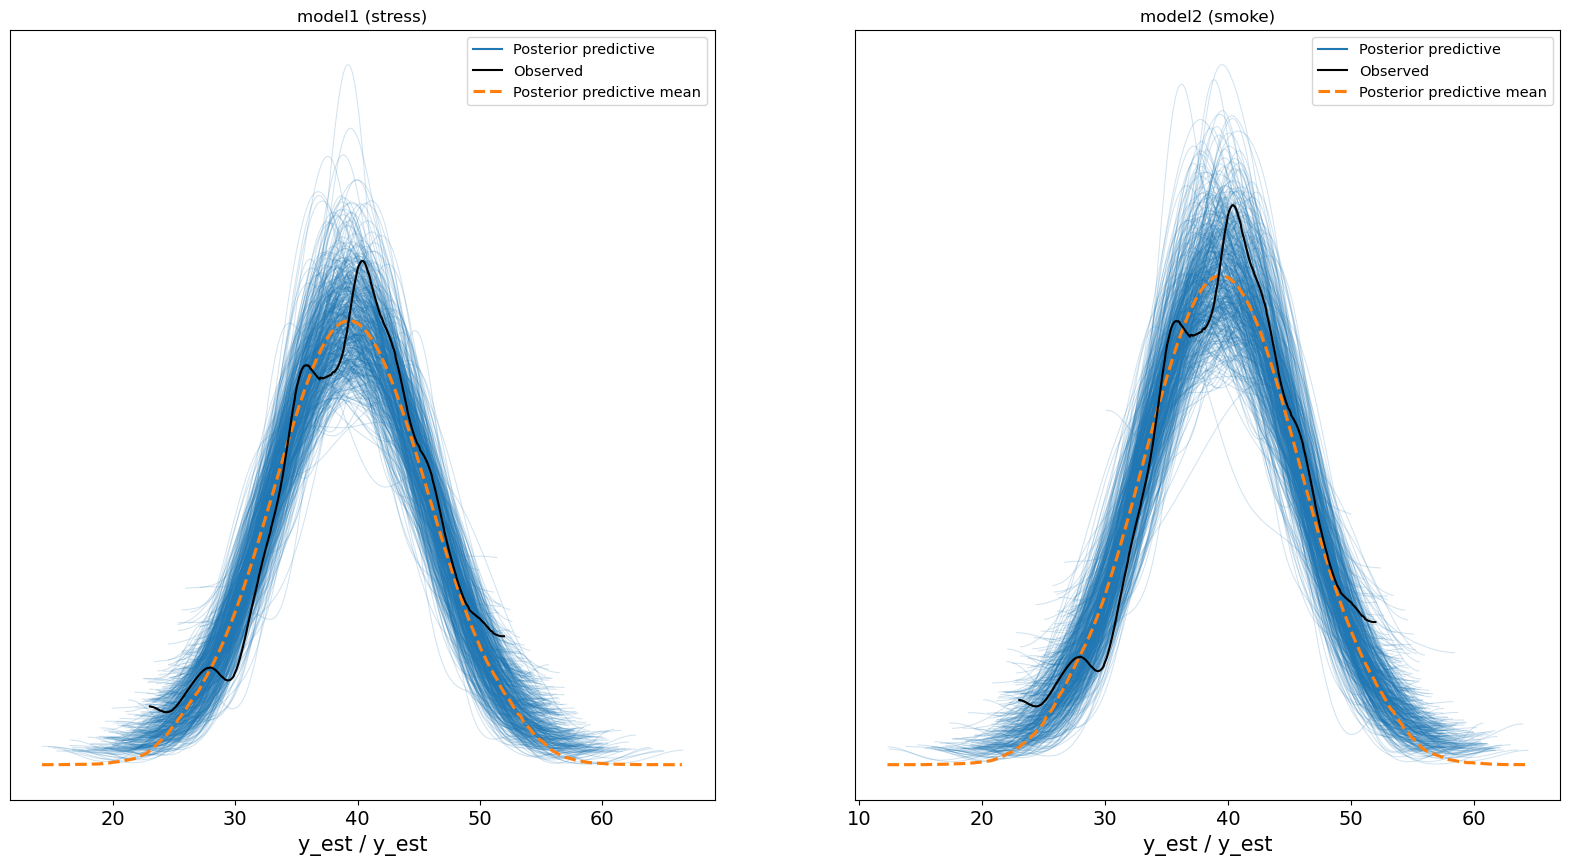

In [8]:
# 定义两个模型ppc可视化的画布
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# 绘制模型1 ppc
az.plot_ppc(model1_ppc, num_pp_samples=500, ax=axes[0])
axes[0].set_title("model1 (stress)")
# 绘制模型2 ppc
az.plot_ppc(model2_ppc, num_pp_samples=500, ax=axes[1])
axes[1].set_title("model2 (smoke)")

plt.show()

## 多元线性回归：增加预测变量  

之前的两个模型，我们分辨考虑两个预测变量对于模型的预测性能。  

🤔 是否可以将吸烟情况和压力同时加入到模型中?  


### 模型定义  

$$  
 
\begin{array}{lcrl}  

\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2)  \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} \\  
\text{priors:} & & \beta_{0}  & \sim N\left(50, 10^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 10^2 \right) \\  
                    & & \beta_2  & \sim N\left(0, 10^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(0.6)  .\\  
\end{array}  

$$  

**各参数(回归系数)的意义：**  

* 在自变量中，$X_{i2}$为离散变量，`0` 表示不吸烟，`1`表示吸烟  

$$  
X_{i2} = \begin{cases}  
1 & \text{Yes} \\  
0 & \text{No} \\  
\end{cases}  
$$  

在之前自变量仅为离散变量的例子中：  

* 当$X_{i2} = 0$时，$\beta_0  =  \beta_0 + \beta_1 \cdot 0$  

    *  $\beta_0$ 表示不抽烟情况下，自我控制分数的均值  

* 当$X_{i2} = 1$时 $\beta_0 + \beta_1 \cdot 1 = \beta_0 + \beta_1$  

    * $\beta_0 + \beta_1$ 表示抽烟情况下，自我控制分数的均值；则$\beta_1 $表示了从不抽烟到抽烟，自我控制分数的变化程度  

**各参数(回归系数)的意义：**  

在现在的例子中，自变量包括离散变量和连续变量。  

* 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2 \cdot 0 = \beta_0 + \beta_1X_{i1}$  

    * 表示不吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。  

* 当$X_{i2} = 1$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2 \cdot 1 = (\beta_0 + \beta_2) + \beta_1X_{i1}$  

    * 表示吸烟情况下，自我控制分数随压力分数变化的情况。  

> 注意，在该模型中，我们假设在两种吸烟条件下，压力对自我控制的影响是相同的，即不存在吸烟对于压力的调节作用。

🤔思考：  

$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2}$  

- 如果离散变量 $X_{i2}$改变编码，`-1` 表示不吸烟，`1`表示吸烟。此时各回归系数的含义是什么？  

![](https://pic3.zhimg.com/80/v2-f95e51b7e6e26feab9ca91077d9c244e_1440w.webp)  

> 延展阅读：  
> 线性模型中无序因子变量的对比方式与回归系数的关系：原理，困境及其解决 https://zhuanlan.zhihu.com/p/88270555  
> 通过线性模型详解方差分析中“对比”（Contrasts）的数理原理 https://zhuanlan.zhihu.com/p/119394473

**直接运行模型定义、MCMC采样、后验预测部分**

In [9]:
with pm.Model() as model3:

    beta_0 = pm.Normal("beta_0", mu=50, sigma=10)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)           #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)           #定义beta_2
    sigma = pm.Exponential("sigma", 0.6)                   #定义sigma

    stress = pm.MutableData("stress",df.stress, dims="obs_id")                           #自变量1:压力水平
    smoke = pm.MutableData("smoke",df.smoke, dims="obs_id")                              #自变量2:是否吸烟
    mu = pm.Deterministic("mu", beta_0 + beta_1*stress + beta_2*smoke, dims="obs_id")    #定义mu，自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.scontrol, dims="obs_id") 

In [10]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with model3:
    model3_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 90 seconds.


In [11]:
with model3:
    model3_ppc = pm.sample_posterior_predictive(model3_trace, random_seed=84735) 

Sampling: [y_est]


### 可视化后验预测结果  

#### 后验预测的线性模型  

我们可以分别查看**吸烟情况**与**压力**对**自我控制**的预测情况  

1. $\mu_i = \beta_0 + \beta_1X_{i1}$：自我控制分数随压力分数变化的情况  

2. $\mu_i = \beta_0 + \beta_2X_{i2}$：自我控制分数随吸烟变化的情况  


In [12]:
az.summary(model3_trace, kind = "stats")

,mean,sd,hdi_3%,hdi_97%
beta_0,55.814,2.505,51.143,60.634
beta_1,-0.408,0.062,-0.522,-0.289
beta_2,-1.723,1.648,-4.705,1.471
sigma,5.460,0.294,4.917,6.011
mu[0],40.321,0.444,39.466,41.142
...,...,...,...,...
mu[169],42.767,0.651,41.503,43.953
mu[170],38.690,0.446,37.890,39.573
mu[171],38.690,0.446,37.890,39.573
mu[172],39.913,0.431,39.114,40.743


In [13]:
# 将参数beta_0, beta_1 与自变量 压力分数 进行组合，生成回归线
model3_trace.posterior["stress_ymodel"] = model3_trace.posterior["beta_0"] +\
                                              model3_trace.posterior["beta_1"] * model3_trace.constant_data["stress"]

# 将参数beta_0, beta_2 与自变量 吸烟情况 进行组合，生成回归线
model3_trace.posterior["smoke_ymodel"] = model3_trace.posterior["beta_0"] +\
                                              model3_trace.posterior["beta_2"] * model3_trace.constant_data["smoke"]

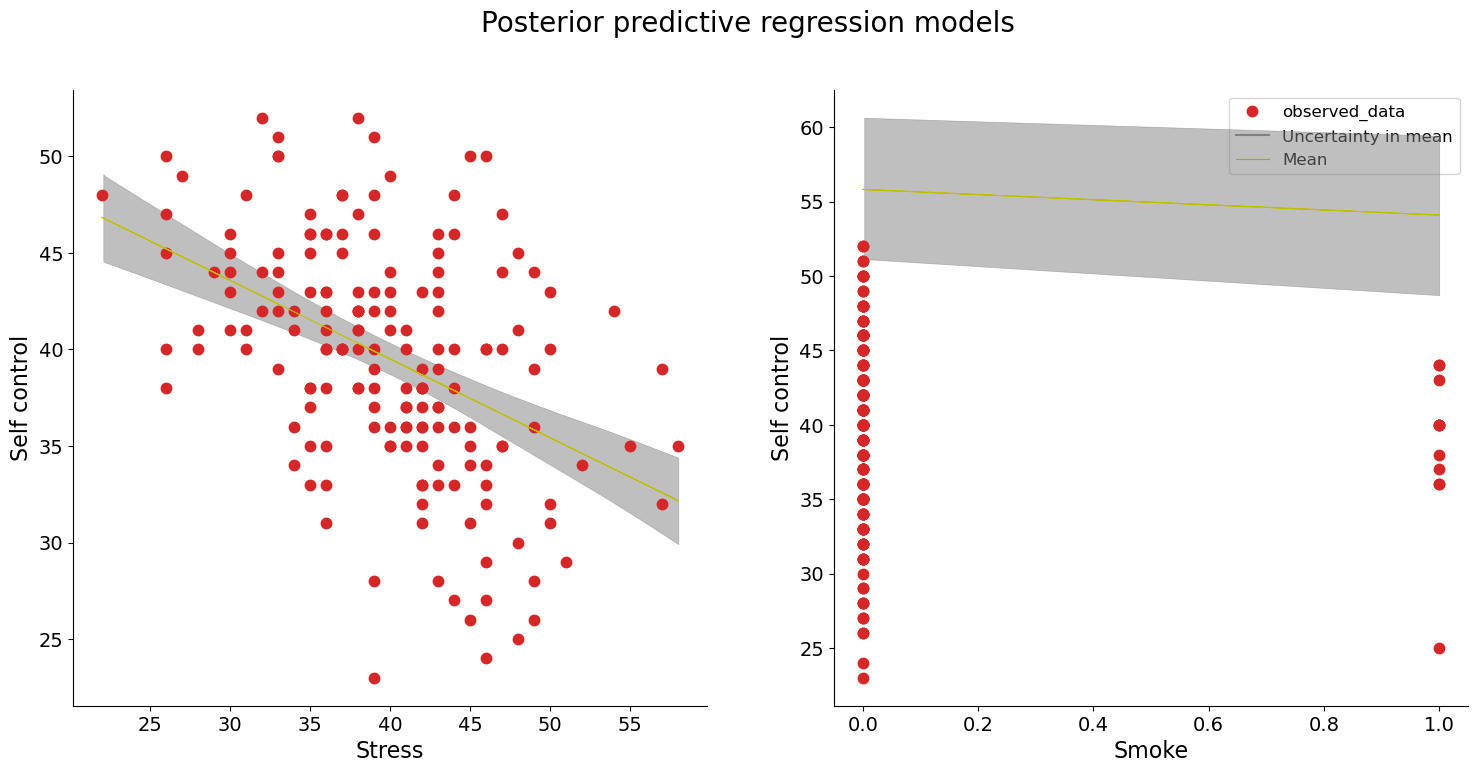

In [14]:
# 定义两幅图的画布
fig, axes = plt.subplots(1,2,figsize=(18, 8))

#----------------------------------------#
#绘制预测变量为压力情况下的后验预测线性模型
az.plot_lm(idata=model3_trace,
           y= "y_est",
           x= "stress",
           y_model = model3_trace.posterior["stress_ymodel"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes[0],
           legend=False,
           y_model_fill_kwargs = {"color":"grey"})
#设置坐标轴标题
axes[0].set_xlabel('Stress', fontsize=16) 
axes[0].set_ylabel('Self control', fontsize=16) 
#----------------------------------------#
#绘制预测变量为吸烟情况下的后验预测线性模型
az.plot_lm(idata=model3_trace,
           y= "y_est",
           x= "smoke",
           y_model = model3_trace.posterior["smoke_ymodel"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes[1],
           y_model_fill_kwargs = {"color":"grey"})

#设置坐标轴标题
axes[1].set_xlabel('Smoke', fontsize=16) 
axes[1].set_ylabel('Self control', fontsize=16) 
#----------------------------------------#
# 设置坐标轴字体大小、图例位置、总标题
axes[0].tick_params(labelsize=14)  
axes[1].tick_params(labelsize=14)
axes[1].legend(loc="upper right", fontsize=12)

fig.suptitle('Posterior predictive regression models', fontsize=20)
sns.despine()

结果发现：  
* 对于吸烟情况的预测出现了偏离，原因在于加入变量压力会影响对于吸烟效应的估计。  
* 可以发现，加入压力变量后，吸烟的效应受到了一定的影响 (-1.75 vs. -1.06)。  
* 但更主要的是，模型截距的变化很大 (55.82 vs. 39.55)

In [15]:
result1 = az.summary(model2_trace, kind="stats")
result2 = az.summary(model3_trace, kind="stats")
print(f"模型2中，截距:{result1.loc['beta_0','mean']:.2f}, 吸烟的回归系数:{result1.loc['beta_1','mean']:.2f}")
print(f"模型3中，截距:{result2.loc['beta_0','mean']:.2f}, 吸烟的回归系数:{result2.loc['beta_2','mean']:.2f}")

模型2中，截距:39.56, 吸烟的回归系数:-1.07
模型3中，截距:55.81, 吸烟的回归系数:-1.72


#### 绘制在不同吸烟状况下，压力对自我控制影响的回归模型  

注意：该模型假设在两种吸烟条件下压力的预测能力相同，因此，两条回归预测线(深绿色)是平行的。

In [16]:
# 分别获取smoke=0及smoke=1时，压力变量对应的索引值
no_smoke_index = xr.DataArray(df.query("smoke == 0")["stress"])["index"].values
smoke_index = xr.DataArray(df.query("smoke == 1")["stress"])["index"].values

In [17]:
# 根据上一步获得的索引值，将参数的后验预测分布分成两部分
# 一部分为吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
# 另一部分为不吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
nosmoke_para = model3_trace.sel(obs_id=no_smoke_index)
smoke_para = model3_trace.sel(obs_id=smoke_index)

In [18]:
# 在不吸烟情况下，将参数与自变量进行组合，生成回归线
nosmoke_para.posterior["y_model"] = nosmoke_para.posterior["beta_0"] +\
                                    nosmoke_para.posterior["beta_1"] * nosmoke_para.constant_data["stress"] +\
                                    nosmoke_para.posterior["beta_2"] * nosmoke_para.constant_data["smoke"]

# 在吸烟情况下，将参数与自变量进行组合，生成回归线
smoke_para.posterior["y_model"] = smoke_para.posterior["beta_0"] +\
                                  smoke_para.posterior["beta_1"] * smoke_para.constant_data["stress"] +\
                                  smoke_para.posterior["beta_2"] * smoke_para.constant_data["smoke"]


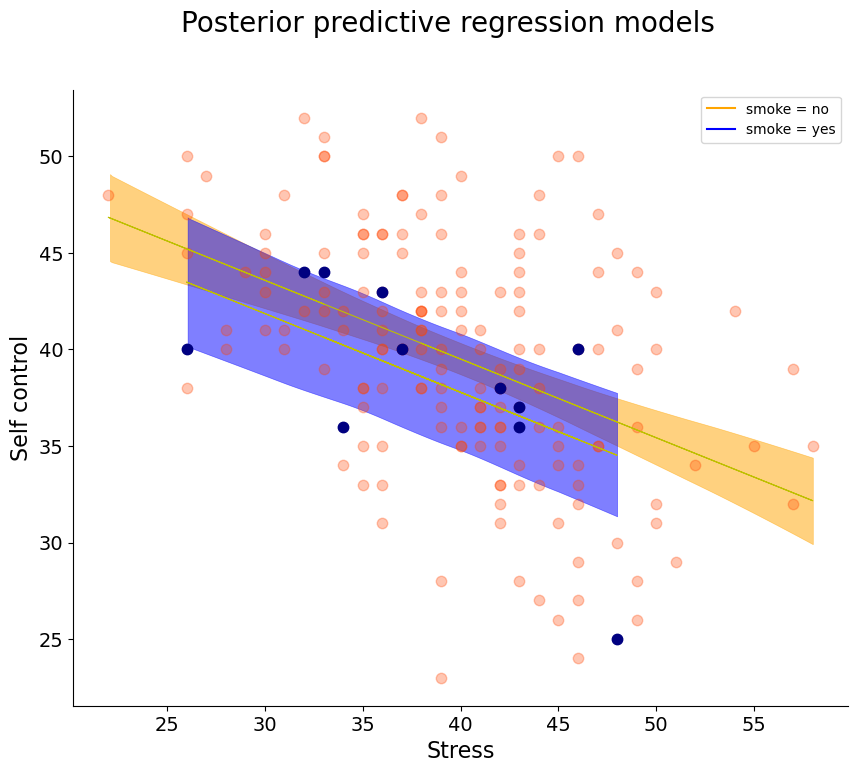

In [19]:
def plot_ppc_lm(nosmoke_para, smoke_para):
    fig, axes = plt.subplots(figsize=(10, 8))

    #绘制smoke=0情况下的后验预测线性模型
    az.plot_lm(idata=nosmoke_para,
            y= "y_est",
            x= "stress",
            y_model = nosmoke_para.posterior["y_model"],
            kind_model = "hdi",
            textsize=15,
            grid=False,
            axes=axes,
            legend=False,
            y_model_fill_kwargs = {"color":"orange"},         # 设置 hdi 区间颜色
            y_kwargs =  {"color":"orangered","alpha":0.3}     # 设置观测值颜色
            )

    #----------------------------------------#
    #绘制smoke=1情况下的后验预测线性模型
    az.plot_lm(idata=smoke_para,
            y= "y_est",
            x= "stress",
            y_model = smoke_para.posterior["y_model"],
            kind_model = "hdi",
            textsize=15,
            grid=False,
            axes=axes,
            y_model_fill_kwargs = {"color":"blue"},         # 设置 hdi 区间颜色
            y_kwargs =  {"color":"navy"},                   # 设置观测值颜色
            legend=False)

    #设置坐标轴标题
    axes.set_xlabel('Stress', fontsize=16) 
    axes.set_ylabel('Self control', fontsize=16) 

    #设置图例
    handles = [
            plt.Line2D([], [], color="orange",
                        label = 'smoke = no'),
            plt.Line2D([], [], color="blue",
                        label = 'smoke = yes')]

    axes.legend(handles=handles)
    #----------------------------------------#
    # 设置坐标轴字体大小、总标题
    axes.tick_params(labelsize=14)  
    fig.suptitle('Posterior predictive regression models', fontsize=20)
    sns.despine()

plot_ppc_lm(nosmoke_para, smoke_para)

#### 后验预测分布

<Axes: xlabel='y_est / y_est'>

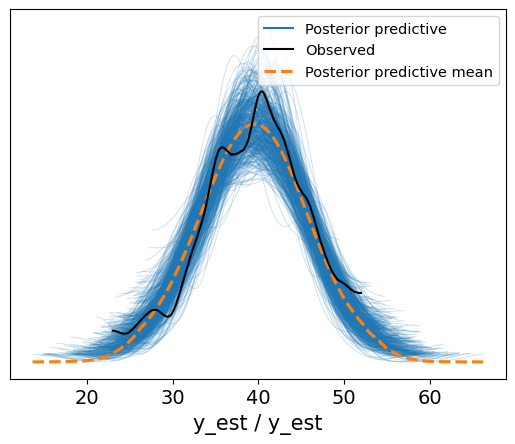

In [20]:
az.plot_ppc(model3_ppc, num_pp_samples = 500)

### 评估后验预测  

#### MAE  

$$  
\text{MAE} = median\left(|Y_i - \hat{Y}_i|\right)  
$$

In [21]:
model3_MAE = MAE(model3_ppc)
print(f"模型3(多元回归)MAE: {model3_MAE:.2f}")

模型3(多元回归)MAE: 3.50


#### 后验预测区间  

* 使用`az.summary`，可以直接得到每个Y后验预测值95%的可信区间  
* 将真实数据与其合并，判断其是否在对应的95%可信区间内，并进行绘图  

> 注意：在真实数据中，一个X可能对应着多个Y，因此可信区间在绘制时会出现重叠

In [22]:
model3_outliers = counter_outlier(model3_ppc)
print(f"模型3(多元回归)超出95%hdi: {model3_outliers:.2f}")

模型3(多元回归)超出95%hdi: 10.00


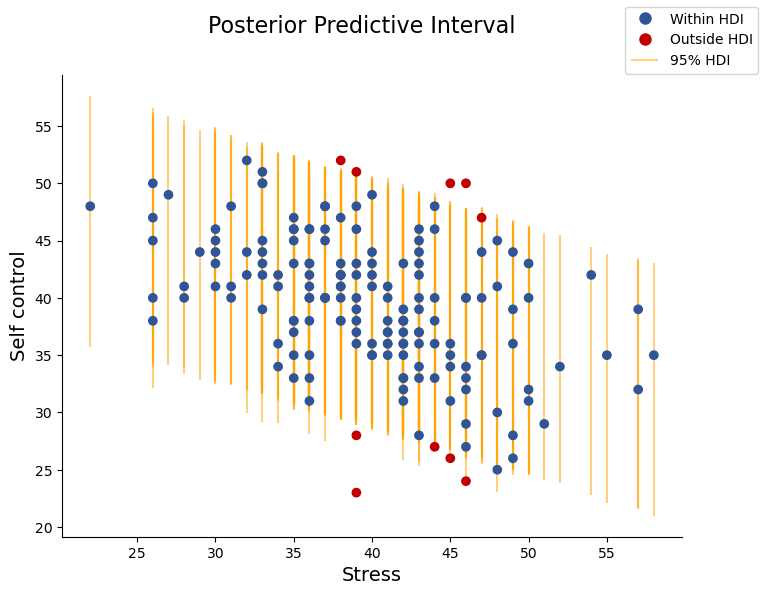

In [23]:
# 定义绘图函数
def plot_ppi(model_ppc):
    fig, ax =  plt.subplots(figsize=(8,6))

    # 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
    hdi_multi = az.summary(model_ppc, hdi_prob=0.95)
    hdi_multi = hdi_multi.reset_index()
    # 将原数据中的压力分数与自我控制分数合并，便于后续进行判断
    hdi_multi["x_obs"] = model_ppc.constant_data["stress"].values
    hdi_multi["y_obs"] = model_ppc.observed_data["y_est"].values

    # 绘制95%的可信区间
    HDI = ax.vlines(hdi_multi["x_obs"], 
            hdi_multi["hdi_2.5%"], hdi_multi["hdi_97.5%"], 
            color="orange", 
            alpha=0.5,
            label="94% HDI")

    #绘制真实值的散点图，并根据是否落在区间内设置观测值的不同颜色
    colors = np.where((hdi_multi["y_obs"] >= hdi_multi["hdi_2.5%"]) & (hdi_multi["y_obs"] <= hdi_multi["hdi_97.5%"]), 
                    '#2F5597', '#C00000')
    ax.scatter(hdi_multi["x_obs"], hdi_multi["y_obs"],
            c = colors,
            zorder = 2)

    # 设置图例的颜色、形状、名称
    legend_color = ['#2F5597', '#C00000']
    handles = [plt.Line2D([0], [0], 
                        marker='o', 
                        color='w', 
                        markerfacecolor=color, markersize=10) for color in legend_color]
    handles += [HDI]
    labels = ['Within HDI', 'Outside HDI','95% HDI']

    # 设置坐标轴名称、标题
    ax.set_xlabel('Stress', fontsize=14) 
    ax.set_ylabel('Self control', fontsize=14)
    fig.legend(handles=handles, labels=labels, loc='outside upper right')
    fig.suptitle('Posterior Predictive Interval', fontsize=16)
    sns.despine()

# 绘制
plot_ppi(model3_ppc)

## 多元线性回归：增加交互项  

* **交互作用：** 存在两个或两个以上自变量时，其中，自变量$X_1$对因变量$Y$的影响在自变量$X_2$的不同水平上有所差异  
    
    * 在本例中，我们可以假设，在不同的吸烟状况下，压力对自我控制的影响略有不同(体现在斜率上)  

![Image Name](https://cdn.kesci.com/upload/s49oqb24we.png?imageView2/0/w/960/h/960)

那么我们可以加入交互项：$\mu = \beta_0 + \beta_1 X_{1} + \beta_2 X_{2} + \beta_3 X_{1}X_{2}$  

$$  
\begin{equation}  
\begin{array}{lcrl}  
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\beta_3,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \beta_3X_{i1}X_{i2} \\  
\text{priors:} & & \beta_{0c}  &  \sim N\left(50, 10^2 \right)  \\  
                     & & \beta_1  & \sim N\left(0, 10^2 \right) \\  
                     & & \beta_2  & \sim N\left(0, 10^2 \right) \\  
                     & & \beta_3  & \sim N\left(0, 10^2 \right) \\  
                     & & \sigma & \sim \text{Exp}(0.6)  .\\  
\end{array}  
\end{equation}  
$$  


**在这个例子中，各参数的意义：**  

* 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1}$  

    * 表示不吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。  

* 当$X_{i2} = 1$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \beta_3X_{i1} = (\beta_0 +\beta_2) + (\beta_1 + \beta_3)X_{i1}$  

    * 表示吸烟情况下，自我控制分数随压力分数变化的情况  
    * 注意截距项和斜率项的变化  
    * 此时压力对自我控制的影响为$(\beta_1 + \beta_3)$，体现了吸烟对这一关系的影响  


**直接运行模型定义、MCMC采样、后验预测部分**

In [24]:
with pm.Model() as model4:
    beta_0 = pm.Normal("beta_0", mu=50, sigma=10)        #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)         #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)         #定义beta_2
    beta_3 = pm.Normal("beta_3", mu=0, sigma=5)          #定义beta_3
    sigma = pm.Exponential("sigma", 0.6)                 #定义sigma

    stress = pm.MutableData("stress",df.stress, dims="obs_id")      #stress是自变量压力水平
    smoke = pm.MutableData("smoke",df.smoke, dims="obs_id")         #smoke是自变量吸烟水平
    mu = pm.Deterministic("mu", beta_0 + 
                                beta_1*stress + 
                                beta_2*smoke +
                                beta_3*stress*smoke, dims="obs_id")      #定义mu，将自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.scontrol, dims="obs_id") 

In [25]:
with model4:
    model4_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                             tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                             chains=4,                     # 链数
                             discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                             random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 108 seconds.


In [26]:
with model4:
    model4_ppc = pm.sample_posterior_predictive(model4_trace, random_seed=84735)

Sampling: [y_est]


### 可视化后验预测结果  

#### 后验预测的线性模型  

我们可以分别查看不同吸烟情况下，压力对自我控制的预测情况  

1. 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1}$：不吸烟情况下，自我控制分数随压力分数变化的情况  

2. 当$X_{i2} = 1$时，$\mu_i = (\beta_0 +  \beta_2) + (\beta_1 + \beta_3)X_{i1}$：吸烟情况下，自我控制分数随压力分数变化的情况  

* 根据吸烟情况($X_{i2} = 0/1$)，将后验参数的预测值分成两部分  

* 代入公式，$\mu = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \beta_3 X_{i1}X_{i2}$，获得对应的后验预测均值  



In [27]:
# 分别获取smoke=0及smoke=1时，压力变量对应的索引值
no_smoke_index = xr.DataArray(df.query("smoke == 0")["stress"])["index"].values
smoke_index = xr.DataArray(df.query("smoke == 1")["stress"])["index"].values

In [28]:
# 根据上一步获得的索引值，将参数的后验预测分布分成两部分
# 一部分为吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
# 另一部分为不吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
in_nosmoke_para = model4_trace.sel(obs_id=no_smoke_index)
in_smoke_para = model4_trace.sel(obs_id=smoke_index)

根据吸烟情况将后验预测数据分成两份  

* 查看 `in_nosmoke_para`:`constant_data`中的`smoke`值全为0，  
* 相对的，`in_smoke_para`:`constant_data`中的`smoke`值全为1，

In [29]:
in_nosmoke_para

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [30]:
in_smoke_para

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

根据回归公式计算不同吸烟条件下的回归预测模型  

$$  
\mu = \beta_0 + \beta_1 X_{1} + \beta_2 X_{2} + \beta_3 X_{1}X_{2}  
$$

In [31]:
# 在不吸烟情况下，将参数与自变量进行组合，生成回归线
in_nosmoke_para.posterior["y_model"] = in_nosmoke_para.posterior["beta_0"] +\
                                    in_nosmoke_para.posterior["beta_1"] * in_nosmoke_para.constant_data["stress"] +\
                                    in_nosmoke_para.posterior["beta_2"] * in_nosmoke_para.constant_data["smoke"] +\
                                    in_nosmoke_para.posterior["beta_3"] * in_nosmoke_para.constant_data["smoke"] * in_nosmoke_para.constant_data["stress"]


In [32]:
# 在吸烟情况下，将参数与自变量进行组合，生成回归线
in_smoke_para.posterior["y_model"] = in_smoke_para.posterior["beta_0"] +\
                                    in_smoke_para.posterior["beta_1"] * in_smoke_para.constant_data["stress"] +\
                                    in_smoke_para.posterior["beta_2"] * in_smoke_para.constant_data["smoke"] +\
                                    in_smoke_para.posterior["beta_3"] * in_smoke_para.constant_data["smoke"] * in_smoke_para.constant_data["stress"]


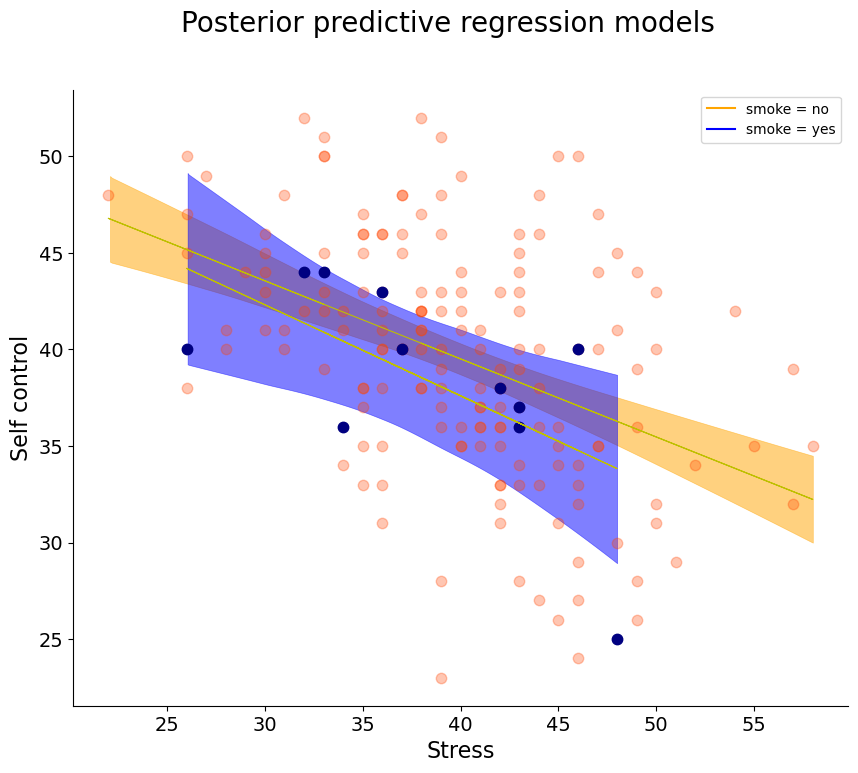

In [33]:
plot_ppc_lm(in_nosmoke_para, in_smoke_para)

我们可以将有交互项和无交互项两种模型生成的回归线进行对比：  

- 我们可以发现，当不加入交互项时(model3)，在两种吸烟条件下，压力对于自我控制的预测是一致的，即两条深绿色线平行。  
- 当加入交互项时(model4)，两种吸烟条件下，两条深绿色线不再平行。  
- 然而，进一步的后验推断可以发现，交互项的效应并不可靠 (后验分布包含0)  


![Image Name](https://cdn.kesci.com/upload/s4g6n11vv5.png?imageView2/0/w/640/h/640)  



<Axes: title={'center': 'beta_3'}>

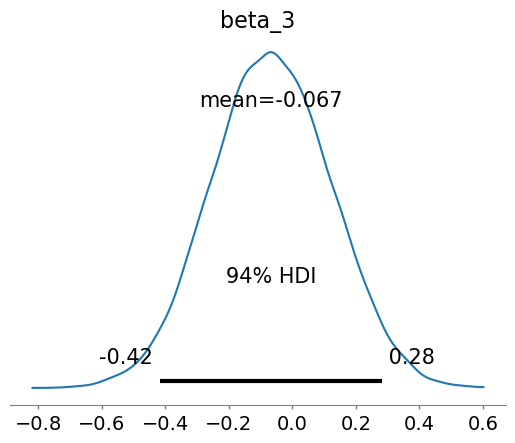

In [34]:
az.plot_posterior(model4_trace, var_names = ["beta_3"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

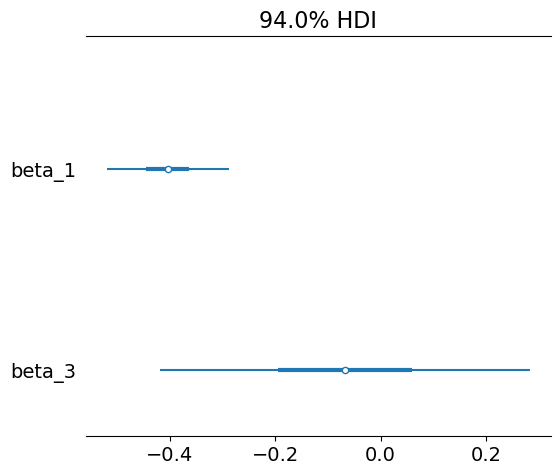

In [35]:
az.plot_forest(model4_trace, var_names = ["beta_1","beta_3"], combined=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

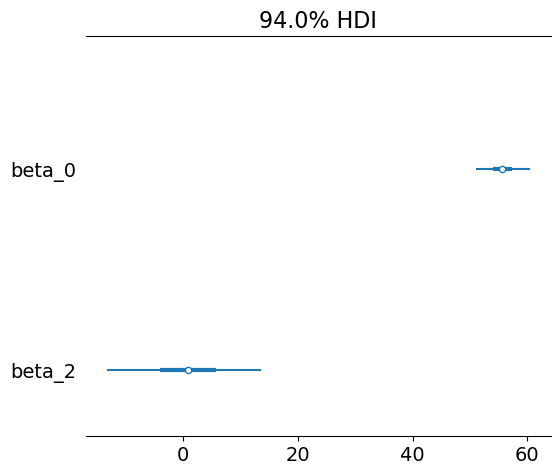

In [36]:
az.plot_forest(model4_trace, var_names = ["beta_0","beta_2"], combined=True)

#### 后验预测分布  

* 通过pymc，绘制当前模型对自我控制分数的后验预测分布

<Axes: xlabel='y_est / y_est'>

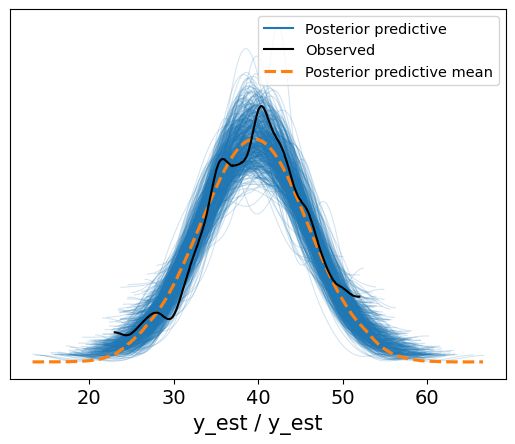

In [37]:
az.plot_ppc(model4_ppc, num_pp_samples=500)

### 评估后验预测  

#### MAE  

$$  
\text{MAE} = median\left(|Y_i - \hat{Y}_i|\right)  
$$

In [38]:
model4_MAE = MAE(model4_ppc)
print(f"模型4(交互模型)MAE: {model4_MAE:.2f}")

模型4(交互模型)MAE: 3.51


#### 后验预测区间  

* 使用`az.summary`，可以直接得到每个Y后验预测值95%的可信区间  
* 将真实数据与其合并，判断其是否在对应的94%可信区间内，并进行绘图  

> 注意：在真实数据中，一个X可能对应着多个Y，因此可信区间在绘制时会出现重叠

In [39]:
model4_outliers = counter_outlier(model4_ppc)
print(f"模型4(交互模型)超出95%hdi: {model4_outliers:.2f}")

模型4(交互模型)超出95%hdi: 8.00


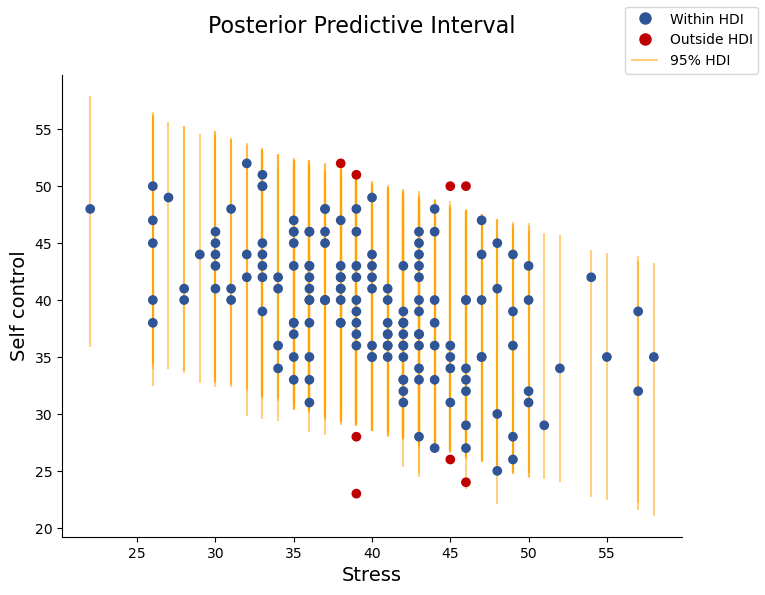

In [40]:
# 绘制
plot_ppi(model4_ppc)

## 总结  

至此，我们已经讨论了四种模型，其汇总结果如下：  

- 四个模型对于后验预测区间外观测值数量的预测得到了相同的结果，即均无法预测174个观测值中的9个。  
- 而对于 MAE而言，以压力为预测变量的线性模型的MAE最低(3.41)，表明其预测性能最好。而以是否吸烟为预测变量的模型MAE最高，其预测性能最低(4.45)。

In [41]:
summary_result = pd.DataFrame({
    "model_name":["continuous model","category model","multi-linear model","interaction model"],
     "MAE":[model1_MAE,model2_MAE,model3_MAE,model4_MAE],
     "HDI_num":[model1_outliers,model2_outliers,model3_outliers,model4_outliers]
     })

summary_result 

,model_name,MAE,HDI_num
0,continuous model,3.400621,9
1,category model,4.447529,9
2,multi-linear model,3.502225,10
3,interaction model,3.513101,8


🎯**开放性练习**  

使用 `METU` 站点的数据进行线性模型分析。  

1. 建立包含两个变量，以及交互项的回归模型  
2. 使用 MAE 和 后验预测区间对模型进行评估。  
4. 进行统计推断，解释模型中各回归系数代表的含义。

## 模型评估与比较 (Model evaluation & comparison)  

关于自我控制的主题，我们已经探索了多种研究假设和多个模型，你可能想知道哪个是最好的模型？  

模型评估与比较(Model evaluation & comparison)的目的在于选择最好的模型。  

什么需要模型比较？  
1. 例如，比较 mode4 和 model3 可以帮助我们确定压力和吸烟之间的交互或调节作用。  
2. 例如，比较 model3 和 model2(或model1) 可以衡量增加预测因子是否能提升模型的预测能力。  
- 总之，模型比较的目的随着研究目的变化而变化。  

|模型|参数|解释|  
|-|-|-|  
|model1|scontrol ~ stress|一般线性回归模型：自变量和因变量均为连续变量|  
|model2|scontrol ~ smoke|一般线性回归模型：自变量为离散变量|  
|model3|scontrol ~ stress + smoke|多元回归模型：自变量为连续变量和离散变量的组合|  
|model4|scontrol ~ stress + smoke + stress:smoke|多元回归模型：自变量额外增加了两个自变量间的交互或调节作用|

### 模型评估的绝对指标和相对指标  

在上节课，我们讨论了三种评价模型的视角：  
- 公平性(How fair)：模型在数据收集和分析的整个流程中的公正性。  
- 错误程度(How wrong)：模型在**实践**中是否有效？即是否能够准确地预测**样本**数据。  
- 准确性(How accurate)：模型是否反映**现实规律**？即是否能够准确地预测**样本外**数据。  

而之前课程所讨论的评估标准(MAE和后验预测区间)都是**绝对指标**，即评估模型在**样本**数据上的预测能力。  

而**相对指标**更多的是评估模型在**样本外**数据上的，这更有利于比较不同模型的预测能力。

**模型评估：对新数据的预测准确性**  

为了评估模型对**样本外数据**的预测能力，我们有以下3种策略：  
1. 通过新数据对模型进行评估。我们可以收集新的数据，并检验模型的预测能力。  
2. 从已有样本中拿出一部分数据用来预测，这被称为**交叉验证(cross validation)** 方法。  
3. 交叉验证的近似方法。例如，使用对交叉验证近似的**信息熵指标**来评估模型对样本外数据的预测能力。

根据第一种策略收集新数据来检验模型的预测能力是一种理所当然的直觉。该策略包括两个主要步骤：  
1. 训练模型：  
   -  首先，我们根据现有的数据训练一个模型。如之前的例子，我们可以训练用压力和吸烟预测自我控制的线性模型。  
2. 测试模型：  
   -  在这阶段，我们需要收集新的数据，并检验模型的预测能力。例如，我们可以将新数据中测量的压力和吸烟数据带入模型，从而获得对于新数据的后验预测数据。最后，计算后验预测数据与新数据的MAE，从而评估模型对样本外数据的预测能力。  

但心理学数据不同于其他学科的数据，它常受到**时间因素**和**抽样**的影响。  
- 比如，个体的压力状态可能随着季节变化，因此在不同季节收集到的数据会受到时间的影响。  
- 又例如，训练模型的数据来自理工科的学生，而测试模型的数据来自心理学的学生。这样抽样的差异也会影响模型对样本外数据的预测能力。  

因此，一种更高效的方法是，一次性多收集一些数据，选择其中的一部分作为预测数据。

### 交叉验证(cross validation)  

但问题在于，我们选择哪一部分数据作为预测数据呐？或者说，我们该如何有效的对数据进行抽取呐？  

**交叉验证(cross validation)** 的目的就在于：提供不同的抽取预测数据的策略  
- 其关键在于从已有样本中拿出一部分数据当作预测数据。  


![](https://pic1.zhimg.com/80/v2-e9ad5ba61cda7ebd02848f336607eb70_1440w.webp)  


> 资料来源：【绝对干货】机器学习模型训练全流程！- 知乎 https://zhuanlan.zhihu.com/p/184673895

常见的交叉验证策略：  
1. 分半交叉验证 (Split-half cross-validation)  
	- 分半交叉验证将观测数据对半分成两部分，分别在不同的数据集上拟合模型，并在另外一半数据集上验证模型，最后再对比不同的模型在两份数据集作为验证集时的预测准确度。  
2. K 折交叉验证 (K-fold cross-validation)  
	- K 折交叉验证把数据分成 K 分，其中一份作为训练集（拟合模型，对参数进行估计），其余的 K-1 分数据集作为验证集，总共重复这个流程 K 次。以 K 次验证结果的均值作为验证标准。  
3. 留一法交叉验证 (Leave-one-out cross-validation)  
	- 留一法交叉验证是 K 折交叉验证的一个特例，当分折的数量等于数据的数量时，K 折留一法便成了留一法交叉验证。留一法交叉验证相较于普通的交叉验证方法，几乎使用了所有数据去训练模型，因此留一法交叉验证的训练模型时的**偏差 (bias) 更小、更鲁棒**，但是又因为验证集只有一个数据点，验证模型的时候**留一法交叉验证的方差 (Variance) 也会更大**。

**K 折交叉验证 (K-fold cross-validation)**  

K 折交叉验证在分半交叉验证的基础上，将数据集分成 K 份(称为 CV-K)，其中一份作为测试集，其余 K-1 份作为训练集，重复这个流程 K 次。  

K 折交叉验证，以 K 次测试结果的**均值**作为验证标准。例如，在压力-自我控制的例子中：  
- 我们可以使用 K=5 折的交叉验证，将数据集分成 5 份，每次使用 5 份数据作为训练集，1份数据作为测试集。  
- 对每一次迭代，我们使用 5 份数据训练模型，然后使用剩下的一份数据进行测试，并计算相应的MAE。  
- 重复这个流程 5 次，然后取每次MAE测试结果的均值作为最终的测试结果。  

![](https://pic3.zhimg.com/80/v2-ff846ee7eefdcd425e123d9d31b4d58a_1440w.webp)  

> 资料来源：【绝对干货】机器学习模型训练全流程！- 知乎 https://zhuanlan.zhihu.com/p/184673895

**留一法交叉验证 (Leave-one-out cross-validation)**  

留一法交叉验证是 K 折交叉验证的一个特例，当分折的数量K等于数据的数量n时，K 折留一法便成了留一法交叉验证。  
- 留一法交叉验证相较于普通的交叉验证方法，几乎使用了所有数据去训练模型。  
- 留一法交叉验证 (Leave-one-out cross-validation)的缩写为 loo-cv，或者 loo。  

![](https://www.baeldung.com/wp-content/uploads/sites/4/2022/05/loso.png)  

> 资料来源：https://www.baeldung.com/cs/cross-validation-k-fold-loo

### ELPD (Expected log-predictive density)  

留一法交叉验证 LOO (包括之前的交叉验证方法)是用于评估模型在**未知数据**上预测能力的思想框架，其本身并不提供具体的统计指标。  

**ELPD** (Expected log-predictive density) 是 LOO 方法的具体实现，以对数似然函数作为统计指标。  

其计算步骤：  
- 同 K 折交叉验证一样，首先将数据集分成 n 份，n为数据总的数量。  
- 利用 n-1 份数据去训练模型，得到后验模型 $p(\theta_{-i}|y_{-i})$。  
- 使用剩下的一份数据作为测试数据 $y_{i}$，计算后验预测模型 $p(y_{i}|y_{-i})$。  
- 重以上过程，重复 n 次，得到 n 个后验预测模型,并计算其对数化后的期望值 $E(log(p(y_{i}|y_{-i})))$。  


![Image Name](https://cdn.kesci.com/upload/s4bmgg7han.png?imageView2/0/w/640/h/640)  


在实际操作中，我们通过 `ArViz` 的函数`az.loo`计算 $ELPD_{LOO-CV}$。  

* 在`az.loo`返回的值中，`elpd_loo` 为$E(log(p(y_{i}|y_{-i})))$，  
* `elpd_loo`越高表示模型的预测值越精确  

注意：由于 $ELPD_{LOO-CV}$ 的计算量也比较大，ArViz 会使用 Pareto Smooth Importance Sampling Leave Once Out Cross Validation (PSIS-LOO-CV) 来近似 $ELPD_{LOO-CV}$。  

PSIS-LOO-CV 有两大优势：  
1. 计算速度快，且结果稳健  
2. 提供了丰富的模型诊断指标  

注意：  
- 要计算 elpd_loo 需要在采样 `pm.sample` 中加入 `idata_kwargs={"log_likelihood": True}`  
- 或者，在模型采样完成后计算对数似然，即 `with model:  pm.compute_log_likelihood(model_trace)`。

In [42]:
with pm.Model() as model1:

    beta_0 = pm.Normal("beta_0", mu=45, sigma=10)        #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                 #定义sigma

    x = pm.MutableData("smoke",df.stress)                     #x是自变量压力水平
    mu = pm.Deterministic("mu", beta_0 + beta_1*x)            #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.scontrol)


with pm.Model() as model2:

    beta_0 = pm.Normal("beta_0", mu=45, sigma=10)        #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                 #定义sigma

    smoke = pm.MutableData("smoke",df.smoke)            #x为是否吸烟，0 1编码。
    mu = pm.Deterministic("mu", beta_0 + beta_1*smoke)  #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.scontrol)
with pm.Model() as model3:

    beta_0 = pm.Normal("beta_0", mu=50, sigma=10)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)           #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)           #定义beta_2
    sigma = pm.Exponential("sigma", 0.6)                   #定义sigma

    stress = pm.MutableData("stress",df.stress)                           #自变量1:压力水平
    smoke = pm.MutableData("smoke",df.smoke)                              #自变量2:是否吸烟
    mu = pm.Deterministic("mu", beta_0 + beta_1*stress + beta_2*smoke)    #定义mu，自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.scontrol) 
with pm.Model() as model4:
    beta_0 = pm.Normal("beta_0", mu=50, sigma=10)        #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)         #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)         #定义beta_2
    beta_3 = pm.Normal("beta_3", mu=0, sigma=5)          #定义beta_3
    sigma = pm.Exponential("sigma", 0.6)                 #定义sigma

    stress = pm.MutableData("stress",df.stress)      #stress是自变量压力水平
    smoke = pm.MutableData("smoke",df.smoke)         #smoke是自变量吸烟水平
    mu = pm.Deterministic("mu", beta_0 + 
                                beta_1*stress + 
                                beta_2*smoke +
                                beta_3*stress*smoke)      #定义mu，将自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.scontrol) 

#===========================
#     注意！！！以下代码可能需要运行15分钟左右
#===========================
with model1:
    model1_trace = pm.sample(draws=5000,                  # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      idata_kwargs={"log_likelihood": True},
                      random_seed=84735)
with model2:
    model2_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                   # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                    # 链数
                        discard_tuned_samples= True, # tune的结果将在采样结束后被丢弃
                        idata_kwargs={"log_likelihood": True},
                        random_seed=84735)  
with model3:
    model3_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      idata_kwargs={"log_likelihood": True},
                      random_seed=84735)
with model4:
    model4_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                chains=4,                     # 链数
                                discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                idata_kwargs={"log_likelihood": True},
                                random_seed=84735)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 77 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 41 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 102 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 99 seconds.


In [43]:
az.loo(model4_trace)

Computed from 20000 posterior samples and 174 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -545.52     9.45
p_loo        4.02        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      174  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

模型`elpd_loo`的结果为-545.62  

- 然而，仅凭单个值，并不能反映模型的预测精确程度。  
- 虽然 **ELPDs 无法为任何单一模型的后验预测准确性提供可解释的度量，但它在比较多个模型的后验预测准确性时非常有用**。  

我们可以通过 `arviz.compare` 方法来对比多个模型的 elpd。从下面结果可见：  
- 模型1的 elpd_loo 最大，表明它对**样本外数据**的预测性能最好。  
- 而模型2的 elpd_loo 最小，表明它的预测性能最差。  
- 并且这些结果与我们通过 MAE 和 后验预测区间得到的判断一致。  

需要注意的是：  
- arviz 提供的结果包括了 elpd se，这使得我们可以判断两个模型的预测差异 elpd_diff 是否超过两至三个标准误se。  
- 从现在的结果看，模型1，3，4的差异很小；而模型2的和其他模型的差异 (19.15) 已经超过了两个标准误se。表明该模型的预测性能显著的低于其他三个模型。

In [44]:
comparison_list = {
    "model1(contiunous)":model1_trace,
    "model2(category)":model2_trace,
    "model3(multivariate )":model3_trace,
    "model4(interaction)":model4_trace,
}
az.compare(comparison_list)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1(contiunous),0,-544.759144,2.859875,0.000000,0.831178,9.527997,0.000000,False,log
model3(multivariate ),1,-544.934177,3.419242,0.175033,0.168822,9.471720,0.726477,False,log
model4(interaction),2,-545.522796,4.015301,0.763652,0.000000,9.453223,0.767375,False,log
model2(category),3,-563.892448,2.647934,19.133304,0.000000,8.984726,5.271316,False,log


In [45]:
summary_result

,model_name,MAE,HDI_num
0,continuous model,3.400621,9
1,category model,4.447529,9
2,multi-linear model,3.502225,10
3,interaction model,3.513101,8


🤔思考：  

1. 如果你的目标是在不控制任何其他因素的情况下探索吸烟与自我控制之间的关系，你会使用哪种模型？  
    
    - 考虑到模型3(多元回归模型)优于模型2(仅包含吸烟)--因此，选择模型3可能更好地反映吸烟的真实效应，而不是忽略压力的主要作用。  
        
2. 如果你的目标是最大限度地提高模型的预测能力，而在模型中只能选择一个预测因子，您会选择压力还是是否吸烟？  
    
    - 由于模型1优于模型2，如果仅选择一个预测变量的话，选择压力能获得对于自我控制更好的预测。  
        
3. 这四个模型中，哪个模型的**总体预测结果**最好？  
    - 模型1以微弱优势超过了使用所有预测因子的模型4。这表明，在建立模型的过程中，预测因子并不是越多越好。  
    - 事实上，模型4比模型3还差一点，这表明压力和吸烟之间的交互效应很弱，加入两者的交互项，会减弱模型的预测能力。  
 
 因此，为了简单高效，我们更有理由选择模型1或者模型3。  
 
 ![](https://th.bing.com/th/id/R.31c49d0bc73e477eda2cf52fef1b859f?rik=fdM9GvPWnNMg4Q&riu=http%3a%2f%2fwww.esafety.cn%2fblog%2fUploadFiles%2f2018-7%2f51155444445.jpg&ehk=O2MXHgnsmdvS68QMhw6CaIw82aHg2E0q%2fSKKtutAZjk%3d&risl=&pid=ImgRaw&r=0)  
 
 > 资料来源: http://www.esafety.cn/Blog/u/9490/archives/2018/154367.html

**如何增加后验预测的能力？**  

往往有两种通用的策略：  
- 收集更多的数据：  
    - 虽然收集更多的数据并不能改变 Y 和 X 之间潜在的微弱关系，但它可以改善模型对参数后验的估计，从而改进模型的后验预测。  
    - 一些可以考虑的手段，增加数据量(n)，扩大x的范围，扩大后验预测的范围。  
- 加入更多的预测变量：  
    - 例如，在自我控制能力方面，压力比吸烟有更好的预测。  
    - 此外，我们可以通过加入 2 个或更多的预测因子来改进我们的模型及其对 Y 的预测（即同时将压力和吸烟作为预测因子加入模型）。

## 偏差方差权衡(bias-variance trade-off)  

模型比较的例子和结果说明：  
- 如果我们的目标是建立一个能准确预测响应变量 Y 的模型，那么我们就需要包含足够多的预测因子，这样我们就能获得有关 Y 的充分信息。  
- 然而，加入太多的预测因子，有可能适得其反。  

偏差方差权衡就反映了这样一个事实：  
- 当模型越复杂，可能对于样本数据有更好的解释，然而无法解释样本外的数据。  
- 当模型太简单时，模型可能照顾到不同的样本，但对于所有样本的解释力都一般。  

![Image Name](https://vitalflux.com/wp-content/uploads/2020/12/overfitting-and-underfitting-wrt-model-error-vs-complexity-768x443.png)  

资料来源：https://vitalflux.com/overfitting-underfitting-concepts-interview-questions/

模型评估的核心在于模型捕捉到了数据中的关键模式，既非太简单而错过数据中有价值的信息(**欠拟合, underfitting**)，也不会太复杂从而将数据中的噪音加入到模型中(**过拟合, overfitting**)。  

**欠拟合(underfitting)**  

* 欠拟合的模型在当前样本的数据拟合效果不好，且其泛化能力(模型在当前样本外新的数据上的预测的准确度)也同样不佳。  
* 导致欠拟合的原因  
  * 数据特征较少  
    * 数据特征指的是数据的属性，比如第一部分中展示的数据的各个变量就是数据的特征。在所有变量都能独立地对目标变量做出解释的前提下，数据特征越多，数据拟合程度越好。  
  * 模型复杂度过低  
    * 模型的复杂度代表模型能够描述的所有函数，比如线性回归最多能表示所有的线性函数。  
    * 模型的复杂度和模型的参数数量有关，一般来说，模型参数越多，复杂度越高，模型参数越少，复杂度越低。  

**过拟合(overfitting)**  

* 模型在当前样本的数据上的拟合程度极好，但是泛化能力也较差。  
* 模型把训练样本学习地“太好了”，把样本自身地一些噪音也当作了所有潜在样本都会具有的一些性质，这样就会导致其泛化性能下降。  
* 导致过拟合的原因  
  * 当前样本的噪音过大，模型将噪音当作数据本身的特征  
  * 当数据的有些特征与目标变量无关，这些特征就是噪音，但它也可能被误当作数据特征，这就会造成模型过拟合  
  - 样本选取有误，样本不能代表整体  
  - 模型参数太多，模型复杂度太高  



![Image Name](https://cdn.kesci.com/upload/s4bp7piw04.png?imageView2/0/w/640/h/640)  


资料来源：https://blog.csdn.net/weixin_43378396/article/details/90707493

### 如何避免欠拟合  

- 增加数据的特征  

- 增加模型复杂度  

### 如何避免过拟合  

- 选择更具代表性的数据  

- 降低模型复杂度  


**问题的本质在于：模型与数据真实的生成模型匹配**  

为了选择一个能够在过拟合和欠拟合之间的达到平衡的最佳模型，就需要进行模型评估、比较和选择。

## workflow  

**概念区别：模型诊断(model diagnostic) vs. 模型验证(model validation)**  

在贝叶斯的workflow中，  

- MCMC评估是对MCMC进行检验，在Gelman et al (2020)中也被称为计算过程的验证(validate computation)，其核心在于确定MCMC算法采样得到的样本是否足以提供目标分布的精确近似。  

- 模型评估则是指对模型是否公平性、有效性、可信性进行评估，既可以是对单个模型，也可以是对多个模型进行。  

理想情况下，两种评估结果都是良好的。然而，情况并非总是如此。  
  - 我们可能有一个很好的模型框架，但是MCMC链的结果却不稳定，进而导致不准确的后验近似。  
  - 或者刚好相反，我们可以获得很好地后验近似，但模型本身却并不反映任何事实。  

![Image Name](https://cdn.kesci.com/upload/image/rkz1dqyo2e.png?imageView2/0/w/960/h/960)

🎯**开放性练习**  

请使用 `METU` 站点的数据完成整个贝叶斯 workflow 的分析。  
1. 根据研究问题或假设建立多个回归模型。需要自行决定每个回归模型的预测变量和先验。  
2. 使用 pymc 或者 bambi 拟合模型。  
3. 进行模型评估，包括通过 LOO 方法进行模型比较，以及对最优模型进行后验预测检验和后验预测数据的分析。  
4. 进行统计推断，报告参数的后验估计结果(参数后验的均值以及95HDI)。

## 总结  

本节课以不同模型的评估为视角，介绍了模型评估和比较的思想  

至此我们也对贝叶斯分析的全流程(Bayesian workflow)有了一个初步的认识  

之后的课程中，我们会不断实践这个流程，让大家感受贝叶斯分析的魅力。  

![Image Name](https://cdn.kesci.com/upload/image/rkz1ehen1l.png?imageView2/0/w/960/h/960)

**补充：**  

之前讨论过模型评估中两种类型的指标：  
- 绝对指标，衡量模型对于样本的预测能力。  
- 相对指标，衡量模型对于样本外数据的预测能力，也考虑了模型的复杂度。  

这两种指标包含了多种具体的统计值：  

模型拟合优度的方法包括：  
- MAE or MSE(mean square error)  
- 对数似然 (log likelihood)  
- $R^2$  

模型预测进度的方法包括：  
- AIC  
- DIC  
- WAIC  
- LOO-CV  


|                    | AIC                                  | DIC                                      | WAIC       | LOOCV           | BIC                                  |  
| ------------------ | ------------------------------------ | ---------------------------------------- | ---------- | --------------- | ------------------------------------ |  
| 适用框架           | 频率论                               | 贝叶斯                                   | 贝叶斯     | 贝叶斯          | 贝叶斯/频率论                        |  
| 偏差（deviance）   | 最大似然参数 $\theta_mle$ 的对数似然 | 贝叶斯参数均值 $\bar{\theta}$ 的对数似然 | LPPD       | $ELPD_{LOO-CV}$ | 最大似然参数 $\theta_mle$ 的对数似然 |  
| 矫正（correction） | 参数数量                             | 似然的变异                               | 似然的变异 |     由于采用 LOO-CV 思想，因此不需要矫正            | 参数数量+数据数量                    |